In [42]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import os

palette = sns.color_palette("dark:salmon", as_cmap=True)


In [15]:
full_df = pd.read_csv("series_data.csv", low_memory=False)
image_output_directory = "./images"
table_output_directory = "./tables"

os.makedirs(image_output_directory, exist_ok=True)
os.makedirs(table_output_directory, exist_ok=True)

full_df.head()

,step,value,timestamp,namespace,metric,run_id,tags,architecture,augmentation_policy,dataset,loss_function,noise_level,alpha,lr,lr_method,method,num_classes,selectively_backpropagate,margin_weighting
0,9.0,0.077024,2025-04-02 11:07:03.683,training,accuracy,MED-103,"['cross_entropy', 'complete', 'CIFAR10UB', 'Sc...",mnasnet_small,cifar10,CIFAR10UB,cross_entropy,0.5,0.19,0.0005,plateau,score,10,True,NaN
1,19.0,0.133148,2025-04-02 11:07:05.825,training,accuracy,MED-103,"['cross_entropy', 'complete', 'CIFAR10UB', 'Sc...",mnasnet_small,cifar10,CIFAR10UB,cross_entropy,0.5,0.19,0.0005,plateau,score,10,True,NaN
2,29.0,0.103273,2025-04-02 11:07:07.942,training,accuracy,MED-103,"['cross_entropy', 'complete', 'CIFAR10UB', 'Sc...",mnasnet_small,cifar10,CIFAR10UB,cross_entropy,0.5,0.19,0.0005,plateau,score,10,True,NaN
3,39.0,0.152278,2025-04-02 11:07:10.033,training,accuracy,MED-103,"['cross_entropy', 'complete', 'CIFAR10UB', 'Sc...",mnasnet_small,cifar10,CIFAR10UB,cross_entropy,0.5,0.19,0.0005,plateau,score,10,True,NaN
4,49.0,0.123659,2025-04-02 11:07:12.113,training,accuracy,MED-103,"['cross_entropy', 'complete', 'CIFAR10UB', 'Sc...",mnasnet_small,cifar10,CIFAR10UB,cross_entropy,0.5,0.19,0.0005,plateau,score,10,True,NaN


In [13]:
full_df.columns

Index(['step', 'value', 'timestamp', 'namespace', 'metric', 'run_id', 'tags',
       'alpha', 'loss_function', 'lr', 'lr_method', 'method', 'num_classes',
       'selectively_backpropagate', 'margin_weighting', 'dataset', 'purpose'],
      dtype='object')

In [16]:
def get_dataset(tags):
    if "CityscapesFine" in tags:
        return "Cityscapes"
    elif "CIFAR10" in tags:
        return "CIFAR10"
    else:
        raise ValueError(f"Unknown dataset: {tags}")

In [17]:
def get_purpose(tags):
    if "Method" in tags:
        return "Method"
    elif "Baseline" in tags:
        return "Baseline"
    elif "Standard" in tags:
        return "Standard"
    else:
        raise ValueError(f"Unknown method: {tags}")

In [18]:
def get_activation(tags):
    if "focal" in tags:
        return "FocalLoss"
    else:
        return "CrossEntropyLoss"

In [19]:
full_df["dataset"] = full_df["tags"].apply(lambda x: get_dataset(x))
full_df["timestamp"] = pd.to_datetime(full_df["timestamp"])
full_df["purpose"] = full_df["tags"].apply(lambda x: get_purpose(x))
full_df["loss_function"] = full_df["tags"].apply(lambda x: get_activation(x))

standard_trains = full_df[full_df["method"].isna()]
citl_trains = full_df[~full_df["method"].isna()]
assert len(standard_trains) + len(citl_trains) == len(full_df)

In [20]:
test_metrics = full_df[full_df["metric"].str.startswith('test_')]
val_metrics = full_df[full_df["metric"].str.startswith('val_')]
weight_metrics = full_df[full_df["metric"].str.startswith('weight_')]

baseline_metrics = test_metrics[test_metrics["purpose"] == "Standard"]
method_metrics = test_metrics[test_metrics["purpose"] == "Method"]

baseline_val_metrics = val_metrics[val_metrics["purpose"] == "Standard"]
method_val_metrics = val_metrics[val_metrics["purpose"] == "Method"]


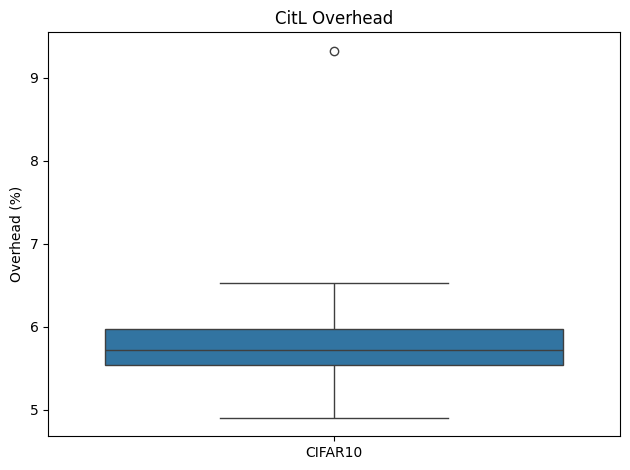

In [21]:
### OVERHEAD
standard_times = standard_trains.groupby(by=["run_id", "dataset"]).agg({"timestamp": ['max', 'min'], "step": "max"})
standard_times["duration"] = (standard_times["timestamp"]["max"] - standard_times["timestamp"]["min"]).dt.total_seconds()
standard_times["steps_per_second"] = standard_times["step"]["max"] / standard_times["duration"]
standard_times = standard_times.reset_index()[["dataset", "steps_per_second"]]
standard_times.columns = [col[0] for col in standard_times.columns]
standard_times = standard_times.groupby(by=["dataset"]).agg({"steps_per_second": "mean"}).reset_index()

citl_times = citl_trains.groupby(by=["run_id", "dataset"]).agg({"timestamp": ['max', 'min'], "step": "max"})
citl_times["duration"] = (citl_times["timestamp"]["max"] - citl_times["timestamp"]["min"]).dt.total_seconds()
citl_times["steps_per_second"] = citl_times["step"]["max"] / citl_times["duration"]
citl_times = citl_times.reset_index()[["dataset", "steps_per_second"]]
citl_times.columns = [col[0] for col in citl_times.columns]

joined_times = pd.merge(standard_times, citl_times, on="dataset", suffixes=("_standard", "_citl"))
joined_times["overhead"] = (joined_times["steps_per_second_standard"] / joined_times["steps_per_second_citl"]) - 1
joined_times = joined_times.reset_index()
joined_times.head()

joined_times["overhead"] = joined_times["overhead"] * 100

box_plot = sns.boxplot(data=joined_times, x="dataset", y="overhead")
ax = box_plot.axes
plt.title("CitL Overhead")
plt.ylabel("Overhead (%)")
plt.xlabel(None)
plt.tight_layout()
plt.savefig(f'{image_output_directory}/overhead.png', dpi=300, bbox_inches='tight')

joined_times.groupby(by=["dataset"])["overhead"].agg(["mean", "std", "min", "max"]).to_latex(f"{table_output_directory}/overhead.tex", float_format="%.2f")

In [11]:
baseline_segmentation_metrics = baseline_metrics[baseline_metrics["dataset"] == "Cityscapes"]

method_segmentation_metrics = method_metrics[method_metrics["dataset"] == "Cityscapes"]

baseline_segmentation_metrics = baseline_segmentation_metrics.pivot(index=["run_id"], columns="metric", values=["value"])
baseline_segmentation_metrics.columns = [col[1] if col[1] else col[0] for col in baseline_segmentation_metrics.columns]

method_segmentation_metrics = method_segmentation_metrics.pivot(index=["run_id", "alpha", "dataset"], columns="metric", values=["value"]).reset_index().sort_values("alpha")
method_segmentation_metrics.columns = [col[1] if col[1] else col[0] for col in method_segmentation_metrics.columns ]

sns.scatterplot(data=method_segmentation_metrics, x="alpha", y="test_jaccard", hue="dataset")
plt.axhline(y=baseline_segmentation_metrics.iloc[0]["test_jaccard"], color='b', linestyle=':', linewidth=1)
plt.ylabel("mIoU")
plt.title("Segmentation Performance")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/segmentation_performance.png', dpi=300, bbox_inches='tight')


ValueError: Could not interpret value `test_jaccard` for `y`. An entry with this name does not appear in `data`.

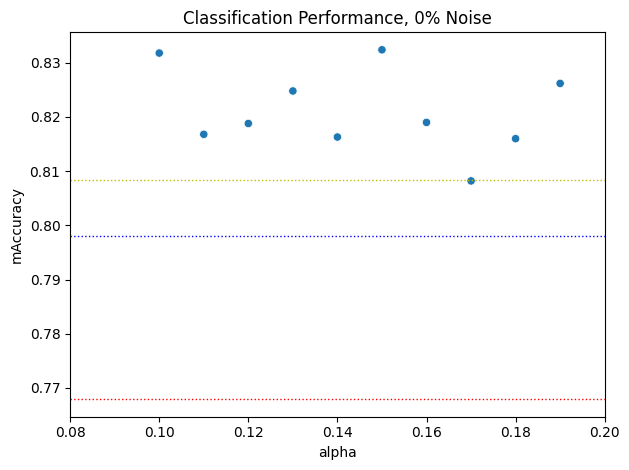

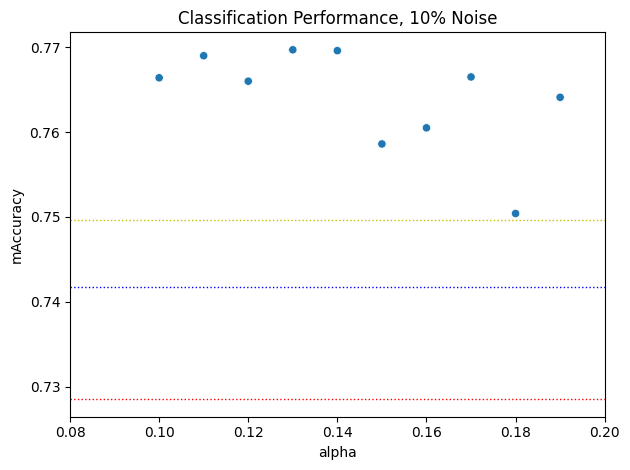

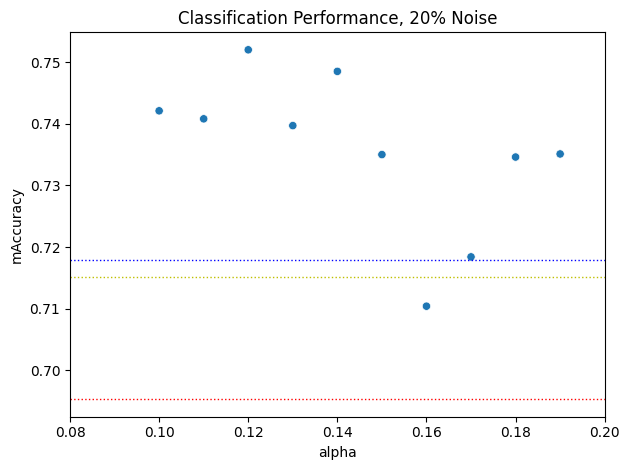

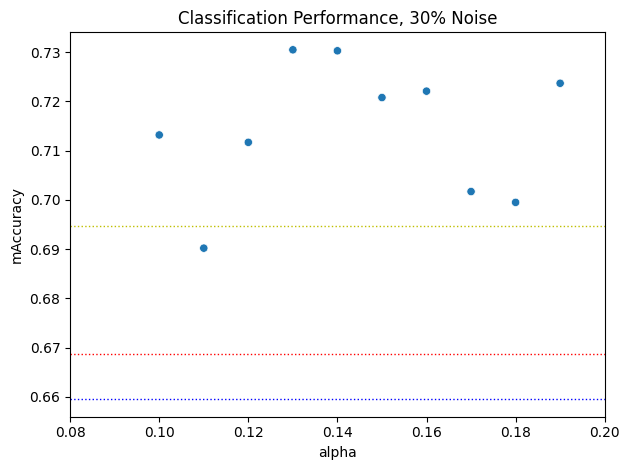

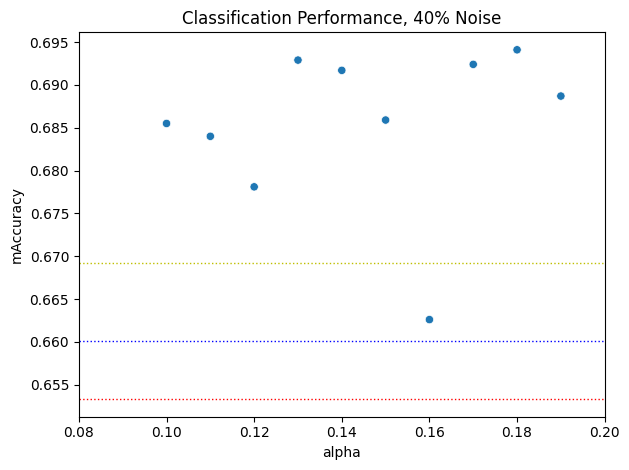

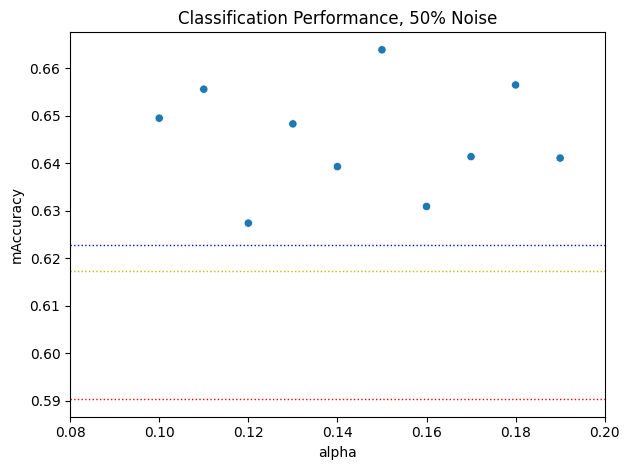

In [ ]:
for noise_level in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    baseline_classification_metrics = baseline_metrics[(baseline_metrics["dataset"] == "CIFAR10")  & (baseline_metrics["noise_level"] == noise_level)]
    baseline_classification_metrics = baseline_classification_metrics.pivot(index=["run_id", "loss_function", "margin_weighting"], columns=["metric"], values=["value"])
    baseline_classification_metrics.columns = [col[1] if col[1] else col[0] for col in baseline_classification_metrics.columns]
    baseline_classification_metrics = baseline_classification_metrics.reset_index()

    method_classification_metrics = method_metrics[(method_metrics["dataset"] == "CIFAR10") & (method_metrics["noise_level"] == noise_level)]

    method_classification_metrics = method_classification_metrics.pivot(index=["run_id", "alpha", "dataset"], columns="metric", values=["value"]).reset_index().sort_values("alpha")
    method_classification_metrics.columns = [col[1] if col[1] else col[0] for col in method_classification_metrics.columns ]

    len_alphas = len(method_classification_metrics['alpha'].unique())
    alphas = np.linspace(method_classification_metrics['alpha'].min(), method_classification_metrics['alpha'].max(), len_alphas)

    sns.scatterplot(data=method_classification_metrics, x="alpha", y="test_accuracy", hue="dataset", legend=False)
    plt.plot()
    plt.axhline(y=baseline_classification_metrics[(baseline_classification_metrics["loss_function"] == "CrossEntropyLoss") & ~baseline_classification_metrics["margin_weighting"]].iloc[0]["test_accuracy"], color='b', linestyle=':', linewidth=1)
    plt.axhline(y=baseline_classification_metrics[baseline_classification_metrics["loss_function"] == "FocalLoss"].iloc[0]["test_accuracy"], color='r', linestyle=':', linewidth=1)
    plt.axhline(y=baseline_classification_metrics[(baseline_classification_metrics["loss_function"] == "CrossEntropyLoss") & baseline_classification_metrics["margin_weighting"]].iloc[0]["test_accuracy"], color='y', linestyle=':', linewidth=1)

    xticks = plt.xticks()[0]  # Get current x-tick positions
    plt.xticks(xticks, [f"{x:.2f}" for x in xticks])  # Set rounded labels

    plt.ylabel("mAccuracy")
    plt.title(f"Classification Performance, {int(noise_level*100)}% Noise")
    plt.tight_layout()
    plt.savefig(f'{image_output_directory}/classification_performance_{noise_level}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


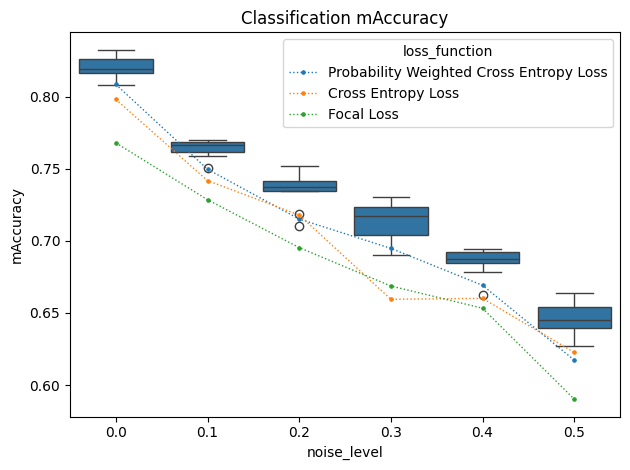

In [40]:
def get_loss(row):
    if row["loss_function"] == "CrossEntropyLoss" and not row["margin_weighting"]:
        return "Cross Entropy Loss"
    elif row["loss_function"] == "CrossEntropyLoss" and row["margin_weighting"]:
        return "Probability Weighted Cross Entropy Loss"
    elif row["loss_function"] == "FocalLoss":
        return "Focal Loss"
    else:
        raise ValueError(f"Unknown loss: {row["loss_function"]} {row["margin_weighting"]}")

best_test_metrics = test_metrics.fillna(0)
cifar_metrics = best_test_metrics[(best_test_metrics["dataset"] == "CIFAR10") & (best_test_metrics["metric"] == "test_accuracy")]
standard_cifar_metrics = cifar_metrics[cifar_metrics["purpose"] == "Standard"]
method_cifar_metrics = cifar_metrics[cifar_metrics["purpose"] == "Method"]

standard_cifar_metrics = standard_cifar_metrics.sort_values("noise_level").sort_values("loss_function")
method_cifar_metrics = method_cifar_metrics.sort_values("noise_level")

standard_cifar_metrics["loss_function"] = standard_cifar_metrics.apply(get_loss, axis=1)

fig, ax = plt.subplots()
sns.boxplot(data=method_cifar_metrics, x="noise_level", y="value", ax=ax, legend='auto')
sns.pointplot(data=standard_cifar_metrics, x="noise_level", y="value", hue="loss_function", linestyle=':', linewidth=1, ax=ax)
plt.ylabel("mAccuracy")
plt.title("Classification mAccuracy")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/classification_performance.png', dpi=300, bbox_inches='tight')


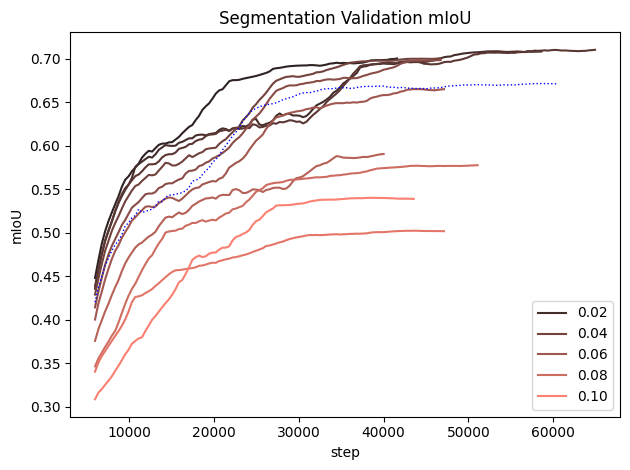

In [ ]:
baseline_val_segmentation_metrics = baseline_val_metrics[baseline_val_metrics["dataset"] == "Cityscapes"]
method_val_segmentation_metrics = method_val_metrics[method_val_metrics["dataset"] == "Cityscapes"]

method_val_segmentation_metrics = method_val_segmentation_metrics.pivot(index=["run_id", "alpha", "dataset", "step"], columns="metric", values=["value"]).reset_index().sort_values("alpha")
method_val_segmentation_metrics.columns = [col[1] if col[1] else col[0] for col in method_val_segmentation_metrics.columns ]

baseline_val_segmentation_metrics = baseline_val_segmentation_metrics.pivot(index=["run_id", "dataset", "step"], columns="metric", values=["value"]).reset_index()
baseline_val_segmentation_metrics.columns = [col[1] if col[1] else col[0] for col in baseline_val_segmentation_metrics.columns ]

window = 15

baseline_val_segmentation_metrics['val_jaccard_smoothed'] = baseline_val_segmentation_metrics['val_jaccard'].rolling(window=window).mean()
method_val_segmentation_metrics = method_val_segmentation_metrics.sort_values("step", ascending=True)
method_val_segmentation_metrics['val_jaccard_smoothed'] = method_val_segmentation_metrics.groupby('alpha')['val_jaccard'].transform(lambda x: x.rolling(window=window).mean())

fig, ax = plt.subplots()
sns.lineplot(data=method_val_segmentation_metrics, x="step", y="val_jaccard_smoothed", hue="alpha", ax=ax, palette=palette, legend='auto')
sns.lineplot(data=baseline_val_segmentation_metrics, x="step", y="val_jaccard_smoothed", color='b', linestyle=':', linewidth=1, ax=ax)
plt.ylabel("mIoU")
plt.title("Segmentation Validation mIoU")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/segmentation_val_miou.png', dpi=300, bbox_inches='tight')


/var/folders/m3/m77fmgpx6tz41_zzh70c3nlc0000gn/T/ipykernel_5128/2225074724.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  weight_results = weight_metrics.fillna(0)


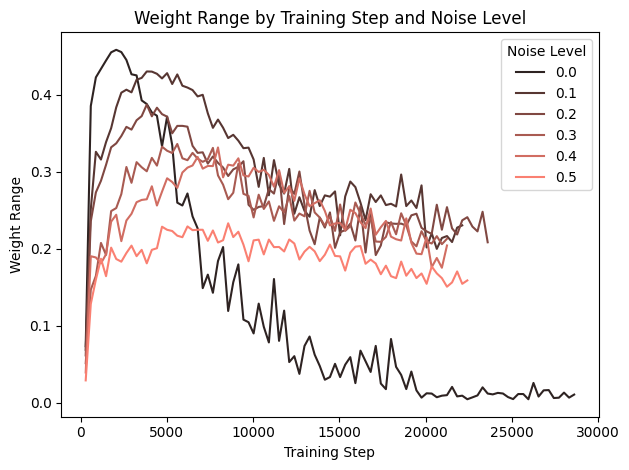

In [43]:
weight_results = weight_metrics.fillna(0)

weight_results = weight_results[
    ( weight_results["dataset"] == "CIFAR10") &
    ( weight_results["purpose"] == "Method") &
    (
        ((weight_results["noise_level"] == 0.0) & (weight_results["alpha"] == 0.18)) |
        ((weight_results["noise_level"] == 0.1) & (weight_results["alpha"] == 0.11)) |
        ((weight_results["noise_level"] == 0.2) & (weight_results["alpha"] == 0.14)) |
        ((weight_results["noise_level"] == 0.3) & (weight_results["alpha"] == 0.13)) |
        ((weight_results["noise_level"] == 0.4) & (weight_results["alpha"] == 0.11)) |
        ((weight_results["noise_level"] == 0.5) & (weight_results["alpha"] == 0.17))
    )
]

weight_results = weight_results.pivot(index=["dataset", "purpose", "noise_level", "alpha", "step", "run_id"], columns="metric", values=["value"])
weight_results.columns = [col[1] if col[1] else col[0] for col in weight_results.columns]

weight_results = weight_results.reset_index()
weight_results = weight_results.rename(columns={"noise_level": "Noise Level"})
fig, ax = plt.subplots()
sns.lineplot(weight_results, x="step", y="weight_range", hue="Noise Level", ax=ax, palette=palette, legend='auto')
plt.ylabel("Weight Range")
plt.xlabel("Training Step")
plt.title("Weight Range by Training Step and Noise Level")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/weight_range.png', dpi=300, bbox_inches='tight')

/var/folders/m3/m77fmgpx6tz41_zzh70c3nlc0000gn/T/ipykernel_5128/2410038285.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  quantile_results = full_df[full_df["metric"].str.startswith('quantile_')].fillna(0)


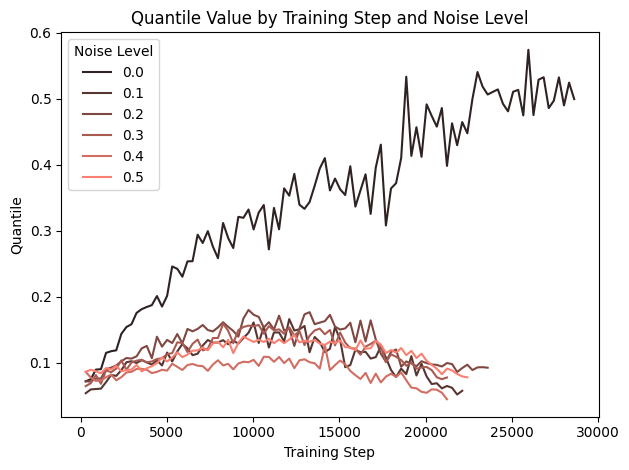

In [44]:
quantile_results = full_df[full_df["metric"].str.startswith('quantile_')].fillna(0)
quantile_results = quantile_results[
    ( quantile_results["dataset"] == "CIFAR10") &
    ( quantile_results["purpose"] == "Method") &
    (
        ((quantile_results["noise_level"] == 0.0) & (quantile_results["alpha"] == 0.18)) |
        ((quantile_results["noise_level"] == 0.1) & (quantile_results["alpha"] == 0.11)) |
        ((quantile_results["noise_level"] == 0.2) & (quantile_results["alpha"] == 0.14)) |
        ((quantile_results["noise_level"] == 0.3) & (quantile_results["alpha"] == 0.13)) |
        ((quantile_results["noise_level"] == 0.4) & (quantile_results["alpha"] == 0.11)) |
        ((quantile_results["noise_level"] == 0.5) & (quantile_results["alpha"] == 0.17))
    )
]

quantile_results["quantile"] = quantile_results["metric"].str.split("_").str[-1]
quantile_results["metric"] = "quantile"
quantile_results = quantile_results.pivot(index=["dataset", "purpose", "noise_level", "alpha", "step", "run_id"], columns="metric", values=["value"])
quantile_results.columns = [col[1] if col[1] else col[0] for col in quantile_results.columns]
quantile_results = quantile_results.reset_index()
quantile_results = quantile_results.rename(columns={"noise_level": "Noise Level"})
fig, ax = plt.subplots()
sns.lineplot(quantile_results, x="step", y="quantile", hue="Noise Level", ax=ax, palette=palette, legend='auto')
plt.ylabel("Quantile")
plt.xlabel("Training Step")
plt.title("Quantile Value by Training Step and Noise Level")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/quantile.png', dpi=300, bbox_inches='tight')


/var/folders/m3/m77fmgpx6tz41_zzh70c3nlc0000gn/T/ipykernel_5128/2551901198.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  quantile_results = full_df[full_df["metric"].str.startswith('quantile_')].fillna(0)


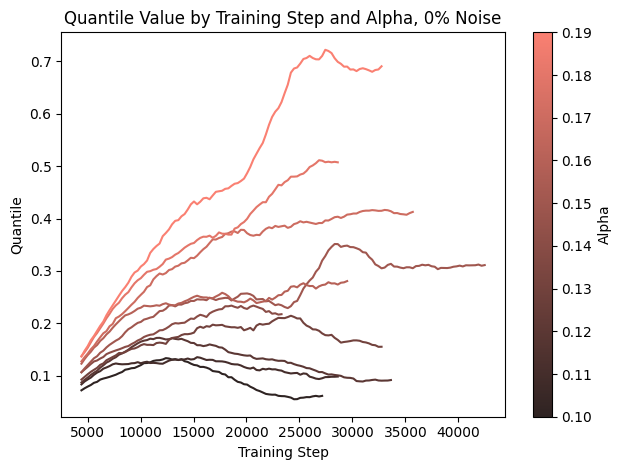

/var/folders/m3/m77fmgpx6tz41_zzh70c3nlc0000gn/T/ipykernel_5128/2551901198.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  quantile_results = full_df[full_df["metric"].str.startswith('quantile_')].fillna(0)


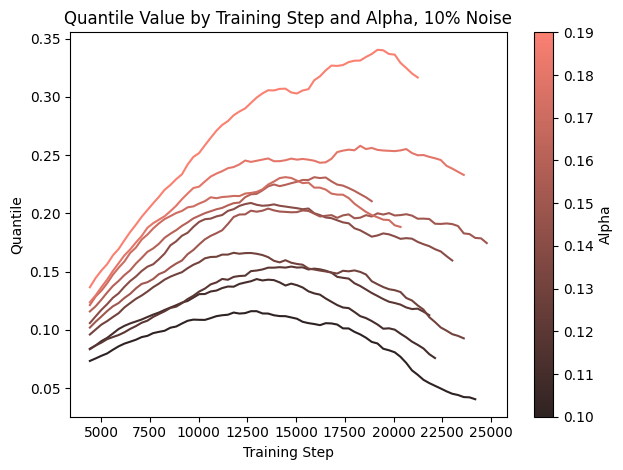

/var/folders/m3/m77fmgpx6tz41_zzh70c3nlc0000gn/T/ipykernel_5128/2551901198.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  quantile_results = full_df[full_df["metric"].str.startswith('quantile_')].fillna(0)


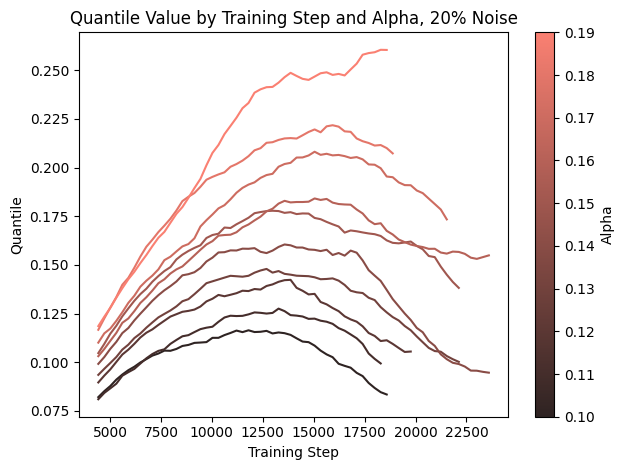

/var/folders/m3/m77fmgpx6tz41_zzh70c3nlc0000gn/T/ipykernel_5128/2551901198.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  quantile_results = full_df[full_df["metric"].str.startswith('quantile_')].fillna(0)


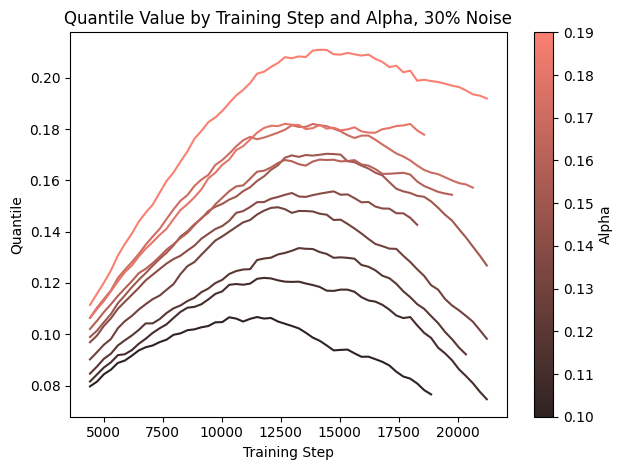

/var/folders/m3/m77fmgpx6tz41_zzh70c3nlc0000gn/T/ipykernel_5128/2551901198.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  quantile_results = full_df[full_df["metric"].str.startswith('quantile_')].fillna(0)


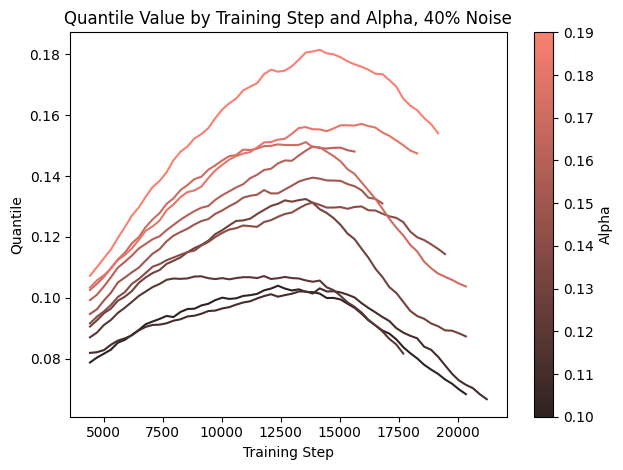

/var/folders/m3/m77fmgpx6tz41_zzh70c3nlc0000gn/T/ipykernel_5128/2551901198.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  quantile_results = full_df[full_df["metric"].str.startswith('quantile_')].fillna(0)


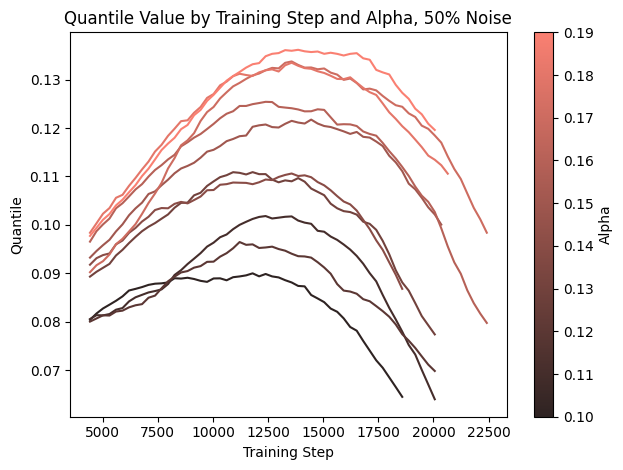

In [46]:
for noise_level in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    quantile_results = full_df[full_df["metric"].str.startswith('quantile_')].fillna(0)
    quantile_results = quantile_results[
        (quantile_results["dataset"] == "CIFAR10") &
        (quantile_results["purpose"] == "Method") &
        (quantile_results["noise_level"] == noise_level)
    ]

    quantile_results["quantile"] = quantile_results["metric"].str.split("_").str[-1]
    quantile_results["metric"] = "quantile"
    quantile_results = quantile_results.pivot(index=["dataset", "purpose", "alpha", "step", "run_id"], columns="metric", values=["value"])
    quantile_results.columns = [col[1] if col[1] else col[0] for col in quantile_results.columns]
    quantile_results = quantile_results.reset_index()
    quantile_results = quantile_results.rename(columns={"noise_level": "Noise Level"})

    quantile_results = quantile_results.sort_values("step", ascending=True)
    window = 15
    quantile_results['quantile_smoothed'] = quantile_results.groupby('alpha')['quantile'].transform(lambda x: x.rolling(window=window).mean())

    fig, ax = plt.subplots()
    sns.lineplot(quantile_results, x="step", y="quantile_smoothed", hue="alpha", ax=ax, palette=palette, legend=False)

    # Add color bar instead of a legend
    norm = plt.Normalize(quantile_results['alpha'].min(), quantile_results['alpha'].max())
    sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    sm.set_array([])

    alphas = len(quantile_results['alpha'].unique())

    # Modify the colorbar to show 10 intervals
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_ticks(np.linspace(quantile_results['alpha'].min(), quantile_results['alpha'].max(), alphas))  # Set 10 ticks
    cbar.set_label("Alpha")

    plt.ylabel("Quantile")
    plt.xlabel("Training Step")
    plt.title(f"Quantile Value by Training Step and Alpha, {int(noise_level*100)}% Noise")
    plt.tight_layout()
    plt.savefig(f'{image_output_directory}/quantile_{noise_level}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    

In [47]:
quantile_results = full_df[full_df["metric"].str.startswith('quantile_')].fillna(0)
quantile_results = quantile_results[
    (quantile_results["dataset"] == "Cityscapes") &
    (quantile_results["purpose"] == "Method")
]

quantile_results["quantile"] = quantile_results["metric"].str.split("_").str[-1]
quantile_results["metric"] = "quantile"
quantile_results = quantile_results.pivot(index=["dataset", "purpose", "alpha", "step", "run_id"], columns="metric", values=["value"])
quantile_results.columns = [col[1] if col[1] else col[0] for col in quantile_results.columns]
quantile_results = quantile_results.reset_index()

quantile_results = quantile_results.sort_values("step", ascending=True)
quantile_results['quantile_smoothed'] = quantile_results.groupby('alpha')['quantile'].transform(lambda x: x.rolling(window=window).mean())

fig, ax = plt.subplots()
sns.lineplot(quantile_results, x="step", y="quantile_smoothed", hue="alpha", ax=ax, palette=palette, legend=False)

# Add color bar instead of a legend
norm = plt.Normalize(quantile_results['alpha'].min(), quantile_results['alpha'].max())
sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
sm.set_array([])

alphas = len(quantile_results['alpha'].unique())

# Modify the colorbar to show 10 intervals
cbar = fig.colorbar(sm, ax=ax)
cbar.set_ticks(np.linspace(quantile_results['alpha'].min(), quantile_results['alpha'].max(), alphas))
cbar.set_label("Alpha")

plt.ylabel("Quantile")
plt.xlabel("Training Step")
plt.title(f"Quantile Value by Training Step and Alpha")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/quantile.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

/var/folders/m3/m77fmgpx6tz41_zzh70c3nlc0000gn/T/ipykernel_5128/1164843214.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  quantile_results = full_df[full_df["metric"].str.startswith('quantile_')].fillna(0)


KeyError: 'Column not found: quantile'

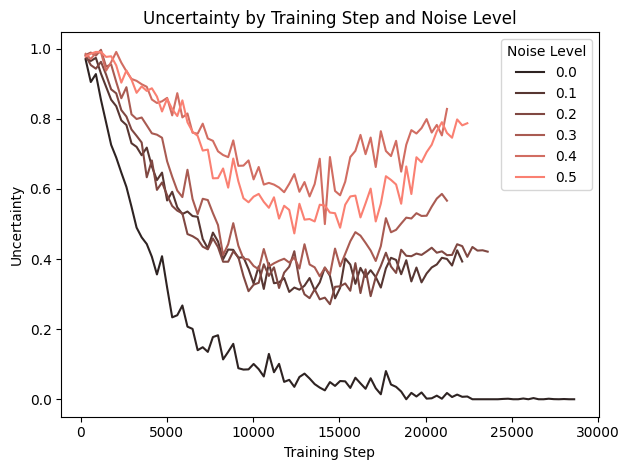

In [48]:
val_results = val_metrics.fillna(0)

val_results = val_results[
    ( val_results["dataset"] == "CIFAR10") &
    ( val_results["purpose"] == "Method") &
    (
        ((val_results["noise_level"] == 0.0) & (val_results["alpha"] == 0.18)) |
        ((val_results["noise_level"] == 0.1) & (val_results["alpha"] == 0.11)) |
        ((val_results["noise_level"] == 0.2) & (val_results["alpha"] == 0.14)) |
        ((val_results["noise_level"] == 0.3) & (val_results["alpha"] == 0.13)) |
        ((val_results["noise_level"] == 0.4) & (val_results["alpha"] == 0.11)) |
        ((val_results["noise_level"] == 0.5) & (val_results["alpha"] == 0.17))
    )
]

val_results = val_results.pivot(index=["dataset", "purpose", "noise_level", "alpha", "step", "run_id"], columns="metric", values=["value"])
val_results.columns = [col[1] if col[1] else col[0] for col in val_results.columns]

val_results = val_results.reset_index()
val_results = val_results.rename(columns={"noise_level": "Noise Level"})
fig, ax = plt.subplots()
sns.lineplot(val_results, x="step", y="val_uncertain", hue="Noise Level", ax=ax, palette=palette, legend='auto')
plt.ylabel("Uncertainty")
plt.xlabel("Training Step")
plt.title("Uncertainty by Training Step and Noise Level")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/uncertainty.png', dpi=300, bbox_inches='tight')

In [49]:
best_test_metrics = test_metrics.fillna(0)
best_test_metrics = best_test_metrics.groupby(by=["purpose", "dataset", "metric", "alpha", "noise_level"]).agg("max")[["value"]].reset_index()
allowed_metrics = [
    "test_accuracy",
    "test_jaccard",
]
best_test_metrics = best_test_metrics[(best_test_metrics["metric"].isin(allowed_metrics))]
best_test_metrics = best_test_metrics[(best_test_metrics["purpose"].isin(["Method", "Standard"]))]
best_test_metrics["metric"] = best_test_metrics["metric"].apply(lambda x: x.replace("test_", "").title())

best_method_metrics = best_test_metrics[best_test_metrics["purpose"] == "Method"].groupby(["dataset", "noise_level", "metric"]).agg("max")[["value"]].reset_index()
best_method_metrics = best_test_metrics.merge(best_method_metrics, on=["dataset", "noise_level", "metric", "value"], how="inner")

best_standard_metrics = best_test_metrics[best_test_metrics["purpose"] == "Standard"].groupby(["dataset", "noise_level", "metric"]).agg("max")[["value"]].reset_index()
best_standard_metrics = best_standard_metrics.groupby(["dataset", "noise_level", "metric"]).agg("max")[["value"]].reset_index()

best_metrics = best_method_metrics.merge(best_standard_metrics, on=["dataset", "noise_level", "metric"], how="inner")
best_metrics = best_metrics.rename(columns={"value_x": "Method", "value_y": "Baseline", "noise_level": "Noise"})
best_metrics["Method"] = best_metrics["Method"] * 100
best_metrics["Baseline"] = best_metrics["Baseline"] * 100
best_metrics["Delta"] = best_metrics["Method"] - best_metrics["Baseline"]
best_metrics["Noise"] = best_metrics["Noise"] * 100
best_metrics["Noise"] = best_metrics["Noise"].map(int)

best_metrics = best_metrics.sort_values(["dataset", "Noise"])
best_metrics = best_metrics.drop(columns=['purpose'])
best_metrics = best_metrics.set_index(['dataset', 'metric', 'Noise'])
best_metrics = best_metrics[['alpha', 'Baseline', 'Method', 'Delta']]
best_metrics.to_latex(f"{table_output_directory}/best_test_metrics.tex", float_format="%.2f")


In [60]:
best_classification_results = test_metrics.fillna(0)
best_classification_results["value"] = best_classification_results["value"] * 100
best_classification_results = best_classification_results[
    ( best_classification_results["dataset"] == "CIFAR10") &
    ( best_classification_results["purpose"] == "Method") &
    ~best_classification_results["margin_weighting"] &
    (
        ((best_classification_results["noise_level"] == 0.0) & (best_classification_results["alpha"] == 0.18)) |
        ((best_classification_results["noise_level"] == 0.1) & (best_classification_results["alpha"] == 0.11)) |
        ((best_classification_results["noise_level"] == 0.2) & (best_classification_results["alpha"] == 0.14)) |
        ((best_classification_results["noise_level"] == 0.3) & (best_classification_results["alpha"] == 0.13)) |
        ((best_classification_results["noise_level"] == 0.4) & (best_classification_results["alpha"] == 0.11)) |
        ((best_classification_results["noise_level"] == 0.5) & (best_classification_results["alpha"] == 0.17))
    )
]

best_classification_results = best_classification_results.pivot(index=["noise_level"], columns="metric", values=["value"])
best_classification_results.columns = [col[1] if col[1] else col[0] for col in best_classification_results.columns]
best_classification_results = best_classification_results.filter(regex='^test_accuracy')
best_classification_results = best_classification_results.rename(columns={"test_accuracy": "Overall"})
best_classification_results.columns = [col.replace('test_accuracy_', '').capitalize() for col in best_classification_results.columns]
best_classification_results = best_classification_results.T
overall_row = best_classification_results.loc['Overall']
best_classification_results = best_classification_results.drop('Overall')
best_classification_results = pd.concat([best_classification_results, overall_row.to_frame().T])

standard_metrics = test_metrics.fillna(0)
standard_metrics["value"] = standard_metrics["value"] * 100

standard_metrics = standard_metrics[
   (standard_metrics["dataset"] == "CIFAR10") &
   (standard_metrics["purpose"] == "Standard") &
   (standard_metrics["loss_function"] == "CrossEntropyLoss") &
   ~standard_metrics["margin_weighting"] ]

standard_metrics["noise_level"].value_counts()

# standard_metrics = standard_metrics.pivot(index=["noise_level"], columns="metric", values=["value"])
# standard_metrics.columns = [col[1] if col[1] else col[0] for col in standard_metrics.columns]
# standard_metrics = standard_metrics.filter(regex='^test_accuracy')
# standard_metrics = standard_metrics.rename(columns={"test_accuracy": "Overall"})
# standard_metrics.columns = [col.replace('test_accuracy_', '').capitalize() for col in standard_metrics.columns]
# standard_metrics = standard_metrics.T
# overall_row = standard_metrics.loc['Overall']
# standard_metrics = standard_metrics.drop('Overall')
# standard_metrics = pd.concat([standard_metrics, overall_row.to_frame().T])

# full_metrics = standard_metrics.merge(best_classification_results, left_index=True, right_index=True, suffixes=("_standard", "_method"))
# full_metrics.columns = pd.MultiIndex.from_tuples([tuple(c.split('_')) for c in full_metrics.columns])
# delta_columns = []

# # Loop through each unique noise level
# for level in set(level for level, method in full_metrics.columns):
#     if (level, 'method') in full_metrics.columns and (level, 'standard') in full_metrics.columns:
#         # Calculate delta as method - standard
#         delta_column_name = (level, 'delta')  # New column name
#         full_metrics[delta_column_name] = full_metrics[(level, 'method')] - full_metrics[(level, 'standard')]
#         delta_columns.append(delta_column_name)


# sorted_columns = sorted(full_metrics.columns, key=lambda x: (x[0], x[1] != 'standard'))
# full_metrics = full_metrics[sorted_columns]
# full_metrics.to_latex(f"{table_output_directory}/classification_metrics_by_class.tex", float_format="%.1f")


noise_level
0.5    24
0.4    24
0.3    24
0.2    24
0.1    24
0.0    24
Name: count, dtype: int64

In [20]:

best_classification_results = test_metrics.fillna(0)
best_classification_results["value"] = best_classification_results["value"] * 100
best_classification_results = best_classification_results[
    ( best_classification_results["dataset"] == "Cityscapes") &
    ( best_classification_results["purpose"] == "Method") &
    ( best_classification_results["alpha"] == 0.02) 
]

best_classification_results = best_classification_results.pivot(index=["run_id"], columns="metric", values=["value"])
best_classification_results.columns = [col[1] if col[1] else col[0] for col in best_classification_results.columns]
best_classification_results = best_classification_results.filter(regex='^test_jaccard')
best_classification_results = best_classification_results.rename(columns={"test_jaccard": "Overall"})
best_classification_results.columns = [col.replace('test_jaccard', '').capitalize() for col in best_classification_results.columns]
best_classification_results = best_classification_results.T
overall_row = best_classification_results.loc['Overall']
best_classification_results = best_classification_results.drop('Overall')
best_classification_results = pd.concat([best_classification_results, overall_row.to_frame().T])

best_classification_results.reset_index(inplace=True)
best_classification_results.columns = ["class", "Method"]

standard_metrics = test_metrics.fillna(0)
standard_metrics["value"] = standard_metrics["value"] * 100

standard_metrics = standard_metrics[
   (standard_metrics["dataset"] == "Cityscapes") &
   (standard_metrics["purpose"] == "Standard")]

standard_metrics = standard_metrics.pivot(index=["run_id"], columns="metric", values=["value"])
standard_metrics.columns = [col[1] if col[1] else col[0] for col in standard_metrics.columns]
standard_metrics = standard_metrics.filter(regex='^test_jaccard')
standard_metrics = standard_metrics.rename(columns={"test_jaccard": "Overall"})
standard_metrics.columns = [col.replace('test_jaccard_', '').capitalize() for col in standard_metrics.columns]
standard_metrics = standard_metrics.T
overall_row = standard_metrics.loc['Overall']
standard_metrics = standard_metrics.drop('Overall')
standard_metrics = pd.concat([standard_metrics, overall_row.to_frame().T])
standard_metrics.reset_index(inplace=True)
standard_metrics.columns = ["class", "Baseline"]
full_metrics = standard_metrics.merge(best_classification_results)
full_metrics["Delta"] = full_metrics["Method"] - full_metrics["Baseline"]

full_metrics.to_latex(f"{table_output_directory}/segmentation_metrics_by_class.tex", float_format="%.1f", index=False)


/var/folders/m3/m77fmgpx6tz41_zzh70c3nlc0000gn/T/ipykernel_3064/716552617.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  atypical_results = full_df[full_df["metric"].str.startswith('atypical')].fillna(0)


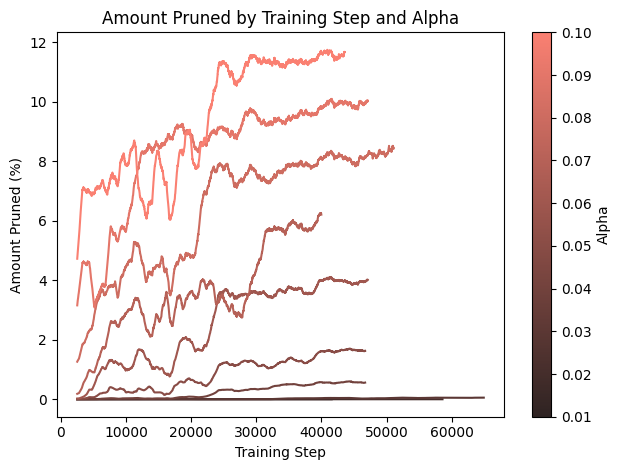

In [23]:
atypical_results = full_df[full_df["metric"].str.startswith('atypical')].fillna(0)
atypical_results = atypical_results[
    (atypical_results["dataset"] == "Cityscapes") &
    (atypical_results["purpose"] == "Method")
]

atypical_results["atypical"] = atypical_results["metric"].str.split("_").str[-1]
atypical_results["metric"] = "atypical"
atypical_results = atypical_results.pivot(index=["dataset", "purpose", "alpha", "step", "run_id"], columns="metric", values=["value"])
atypical_results.columns = [col[1] if col[1] else col[0] for col in atypical_results.columns]
atypical_results = atypical_results.reset_index()

window = 250

atypical_results = atypical_results.sort_values("step", ascending=True)
atypical_results['atypical_smoothed'] = 100 * atypical_results.groupby('alpha')['atypical'].transform(lambda x: x.rolling(window=window).mean())

fig, ax = plt.subplots()
sns.lineplot(atypical_results, x="step", y="atypical_smoothed", hue="alpha", ax=ax, palette=palette, legend=False)

# Add color bar instead of a legend
norm = plt.Normalize(atypical_results['alpha'].min(), atypical_results['alpha'].max())
sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
sm.set_array([])

alphas = len(atypical_results['alpha'].unique())

# Modify the colorbar to show 10 intervals
cbar = fig.colorbar(sm, ax=ax)
cbar.set_ticks(np.linspace(atypical_results['alpha'].min(), atypical_results['alpha'].max(), alphas))
cbar.set_label("Alpha")

plt.ylabel("Amount Pruned (%)")
plt.xlabel("Training Step")
plt.title(f"Amount Pruned by Training Step and Alpha")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/pruned.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

/var/folders/m3/m77fmgpx6tz41_zzh70c3nlc0000gn/T/ipykernel_4037/3301341585.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  atypical_results = full_df[full_df["metric"].str.startswith('atypical')].fillna(0)


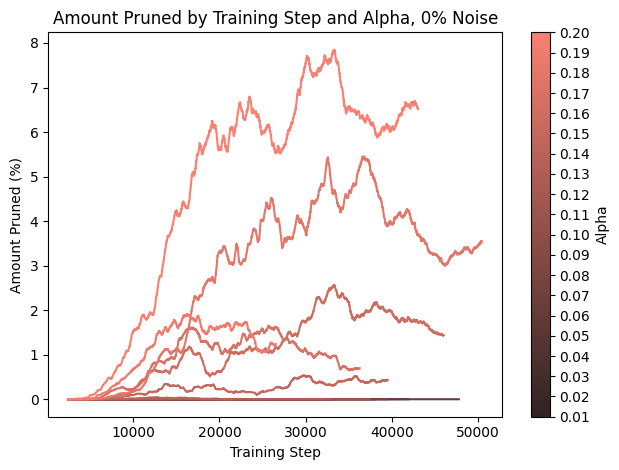

/var/folders/m3/m77fmgpx6tz41_zzh70c3nlc0000gn/T/ipykernel_4037/3301341585.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  atypical_results = full_df[full_df["metric"].str.startswith('atypical')].fillna(0)


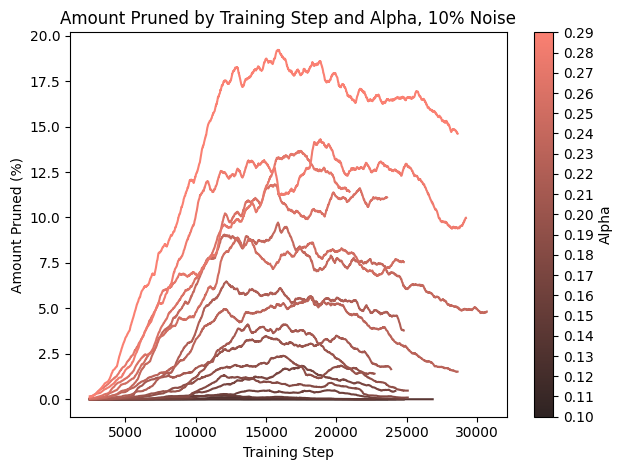

/var/folders/m3/m77fmgpx6tz41_zzh70c3nlc0000gn/T/ipykernel_4037/3301341585.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  atypical_results = full_df[full_df["metric"].str.startswith('atypical')].fillna(0)


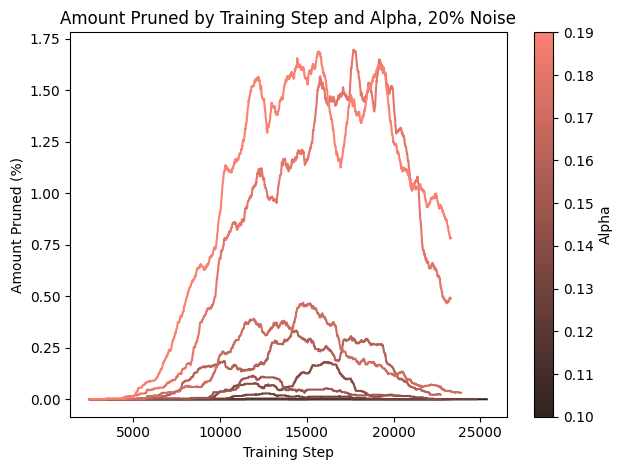

/var/folders/m3/m77fmgpx6tz41_zzh70c3nlc0000gn/T/ipykernel_4037/3301341585.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  atypical_results = full_df[full_df["metric"].str.startswith('atypical')].fillna(0)


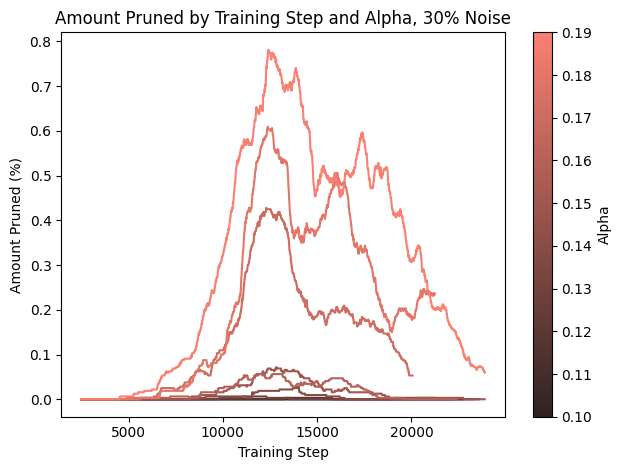

/var/folders/m3/m77fmgpx6tz41_zzh70c3nlc0000gn/T/ipykernel_4037/3301341585.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  atypical_results = full_df[full_df["metric"].str.startswith('atypical')].fillna(0)


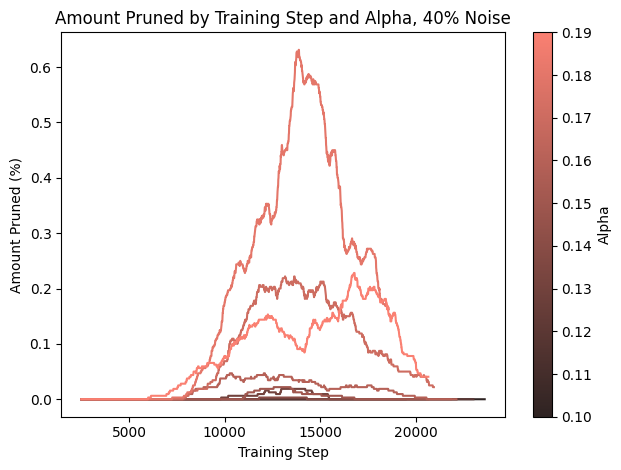

/var/folders/m3/m77fmgpx6tz41_zzh70c3nlc0000gn/T/ipykernel_4037/3301341585.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  atypical_results = full_df[full_df["metric"].str.startswith('atypical')].fillna(0)


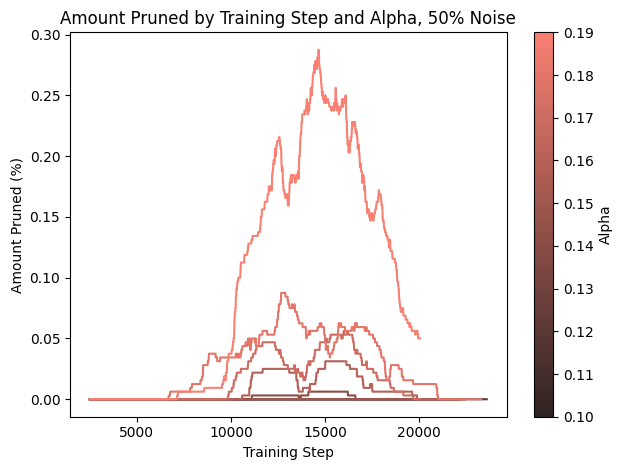

In [30]:
for noise_level in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    atypical_results = full_df[full_df["metric"].str.startswith('atypical')].fillna(0)
    atypical_results = atypical_results[
        (atypical_results["dataset"] == "CIFAR10") &
        (atypical_results["purpose"] == "Method") &
        (atypical_results["noise_level"] == noise_level)
    ]

    atypical_results["atypical"] = atypical_results["metric"].str.split("_").str[-1]
    atypical_results["metric"] = "atypical"
    atypical_results = atypical_results.pivot(index=["dataset", "purpose", "alpha", "step", "run_id"], columns="metric", values=["value"])
    atypical_results.columns = [col[1] if col[1] else col[0] for col in atypical_results.columns]
    atypical_results = atypical_results.reset_index()
    atypical_results = atypical_results.rename(columns={"noise_level": "Noise Level"})

    atypical_results = atypical_results.sort_values("step", ascending=True)
    atypical_results['atypical_smoothed'] = 100* atypical_results.groupby('alpha')['atypical'].transform(lambda x: x.rolling(window=window).mean())

    fig, ax = plt.subplots()
    sns.lineplot(atypical_results, x="step", y="atypical_smoothed", hue="alpha", ax=ax, palette=palette, legend=False)

    # Add color bar instead of a legend
    norm = plt.Normalize(atypical_results['alpha'].min(), atypical_results['alpha'].max())
    sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    sm.set_array([])

    alphas = len(atypical_results['alpha'].unique())

    # Modify the colorbar to show 10 intervals
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_ticks(np.linspace(atypical_results['alpha'].min(), atypical_results['alpha'].max(), alphas))  # Set 10 ticks
    cbar.set_label("Alpha")


    plt.ylabel("Amount Pruned (%)")
    plt.xlabel("Training Step")
    plt.title(f"Amount Pruned by Training Step and Alpha, {int(noise_level*100)}% Noise")
    plt.tight_layout()
    plt.savefig(f'{image_output_directory}/pruned_{noise_level}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    